In [1]:
import openmc
import matplotlib.pyplot as plt

In [2]:
iter_sp = openmc.StatePoint("../reactors/iter_class/statepoint_1e10.100.h5")

In [3]:
iter_tfcoil_spectrum = iter_sp.get_tally(id=4)

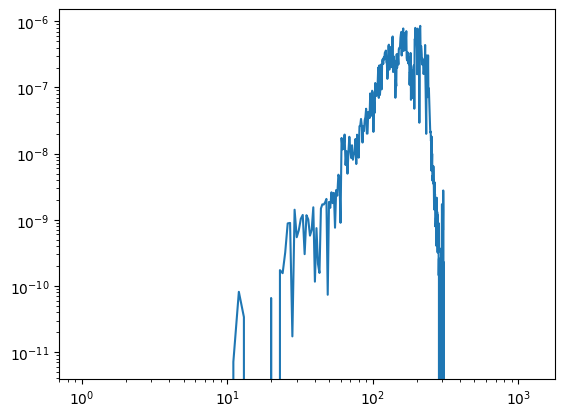

In [5]:
plt.loglog(iter_tfcoil_spectrum.mean[:,0,0])

In [ ]:
plt.loglog(iter_tfcoil_spectrum.std_dev[:,0,0] / iter_tfcoil_spectrum.mean[:,0,0])